Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
832/832 [==============================] - 19s 22ms/step - loss: 0.0015 - val_loss: 3.7179e-04
Epoch 2/20
832/832 [==============================] - 18s 21ms/step - loss: 5.2545e-04 - val_loss: 3.5181e-04
Epoch 3/20
832/832 [==============================] - 18s 21ms/step - loss: 4.9448e-04 - val_loss: 3.3789e-04
Epoch 4/20
832/832 [==============================] - 

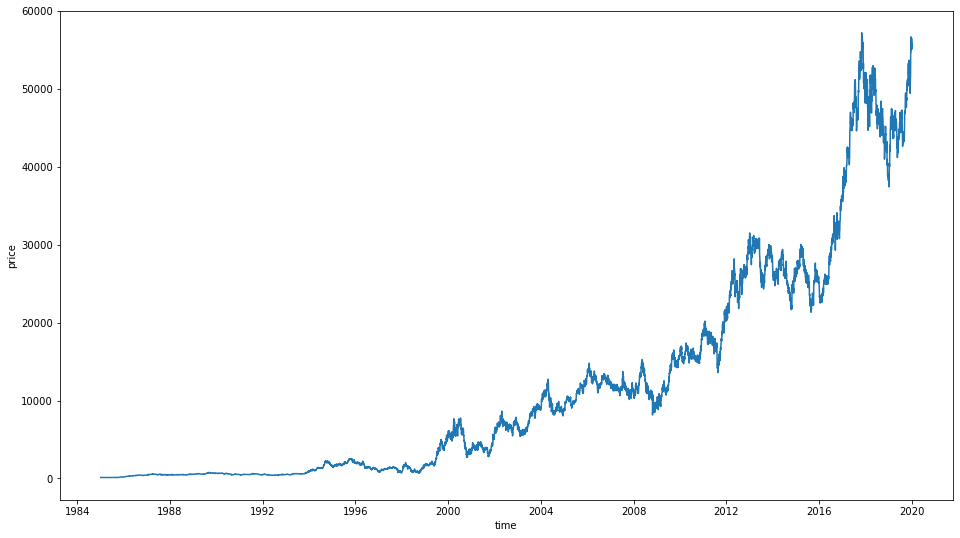

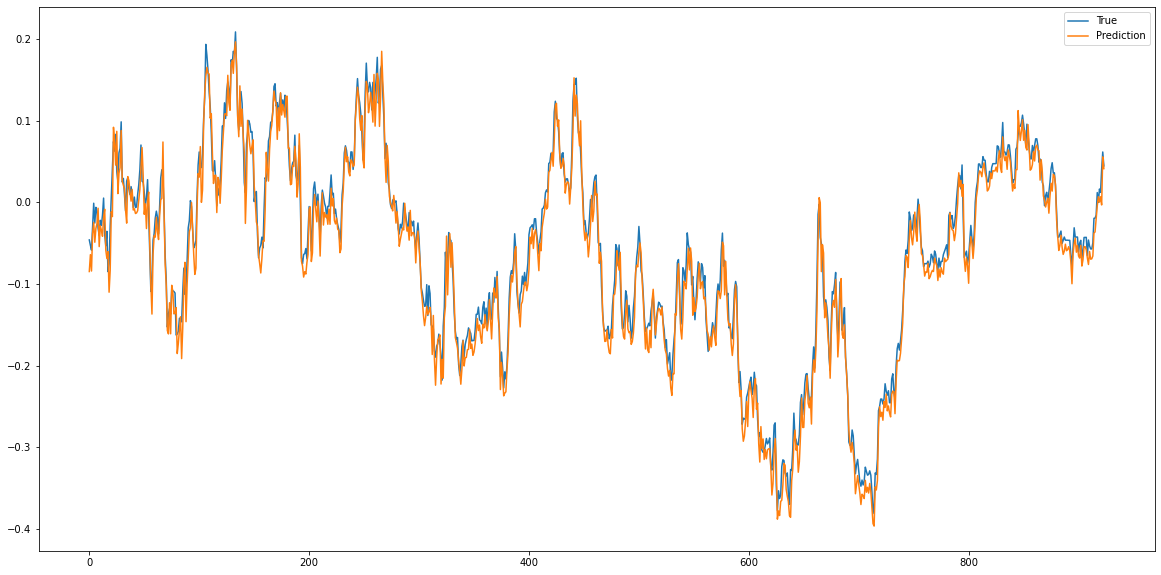

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


############### 데이터 읽어오기 #####################################
df_price = pd.read_csv('./삼성주가데이터.csv', encoding='utf8')
df_price .describe()

############### 데이터 전처리 #####################################
pd.to_datetime(df_price['일자'], format='%Y%m%d')

df_price['일자'] = pd.to_datetime(df_price['일자'], format = '%Y%m%d')
df_price['연도'] = df_price['일자'].dt.year
df_price['월'] = df_price['일자'].dt.month
df_price['일'] = df_price['일자'].dt.day

data = df_price.dropna() # 결측치 제거

############### 데이터 시각화 #####################################

# 데이터 시각화(그래프)
plt.figure(figsize = (16, 9))
sns.lineplot(y = df_price['종가'], x = df_price['일자'])
plt.xlabel('time')
plt.ylabel('price')


############### Window 만들기 #####################################

# 가격 예측을 위해 mid_prices컬럼 만들기
high_prices = df_price['고가'].values
low_prices = df_price['저가'].values
mid_prices = (high_prices + low_prices) / 2

# Window 만들기
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

############### 정규화 #####################################

# Normalization(정규화)
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

############### 학습시킬 데이터 셋 생성 #####################################

# 트레이닝 데이터와 테스트 데이터 나누기
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape
# 8313개의 트레인, 924개의 테스트 셋이 나눠짐
# 8313일의 데이터를 가지고 학습해서 924일의 주식 가격 예측

############### 학습 #####################################

#모델을 순차적으로 정의
model = Sequential()

#LSTM 인풋 50개
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

#인풋 64개(이거는 조정할 수 있음)
model.add(LSTM(64, return_sequences=False))

#다음날 하루의 가격을 예측
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

#50개가 들어가서 1개가 나온다
model.summary()

# 트레이닝 모델 학습 시키기
model.fit(x_train, y_train,
    validation_data=(x_test, y_test), #한번에 몇개씩 묶어서 학습시킬지
    batch_size=10,
    epochs=20)


############### 시각화 #####################################

# 인공지능 결과 시각화
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()


